In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

data_path = "/content/drive/MyDrive/ML_datasets/TESS Toronto emotional speech set data"

In [ ]:
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    print(f"\nFolder: {folder}")
    for i, file in enumerate(os.listdir(folder_path)):
        if i < 5:  # show only first 5 files for brevity
            print("  ", file)


Folder: YAF_neutral
   YAF_dab_neutral.wav
   YAF_chair_neutral.wav
   YAF_base_neutral.wav
   YAF_dog_neutral.wav
   YAF_boat_neutral.wav

Folder: YAF_disgust
   YAF_bite_disgust.wav
   YAF_chair_disgust.wav
   YAF_bought_disgust.wav
   YAF_boat_disgust.wav
   YAF_chalk_disgust.wav

Folder: YAF_sad
   YAF_bar_sad (1).wav
   YAF_bath_sad (1).wav
   YAF_boat_sad.wav
   YAF_bean_sad (1).wav
   YAF_bar_sad.wav

Folder: OAF_Sad
   OAF_half_sad.wav
   OAF_luck_sad.wav
   OAF_keep_sad.wav
   OAF_choice_sad.wav
   OAF_hire_sad.wav

Folder: YAF_angry
   YAF_chat_angry.wav
   YAF_far_angry.wav
   YAF_chain_angry.wav
   YAF_book_angry.wav
   YAF_keg_angry.wav

Folder: OAF_Pleasant_surprise
   OAF_half_ps.wav
   OAF_came_ps.wav
   OAF_hash_ps.wav
   OAF_fall_ps.wav
   OAF_dead_ps.wav

Folder: TESS Toronto emotional speech set data
   YAF_sad
   YAF_pleasant_surprised
   YAF_fear
   YAF_neutral
   YAF_happy

Folder: YAF_fear
   YAF_check_fear.wav
   YAF_fall_fear.wav
   YAF_chalk_fear.wav
   YAF_

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout,LSTM

In [ ]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

In [ ]:
import os

X = []
Y = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if not os.path.isdir(folder_path):
        continue
    emotion = folder.split('_')[-1].lower()

    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            try:
                audio, sr = librosa.load(file_path, duration=3, offset=0.5)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
                mfcc = np.mean(mfcc.T, axis=0)

                # Skip if MFCC shape is incorrect
                if mfcc.shape[0] != 40:
                    continue

                X.append(mfcc)
                Y.append(emotion)
            except Exception as e:
                print(f" Error: {file_path} - {e}")

print("Total samples:", len(X))
print("Unique emotions:", set(Y))

Total samples: 2805
Unique emotions: {'surprise', 'sad', 'neutral', 'disgust', 'fear', 'surprised', 'angry', 'happy'}


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X = np.array(X)
Y = np.array(Y)

le = LabelEncoder()
Y_encoded = to_categorical(le.fit_transform(Y))

In [ ]:
print(Y[:10])  # first 10 labels
print(le.classes_)  # encoded class labels

['neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral']
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise' 'surprised']


In [ ]:
# Train/test split and reshape
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
# Build CNN + LSTM model
model = Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(Y_encoded.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 40, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 20, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,560 (373.28 KB)

 Trainable params: 95,560 (373.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4290 - loss: 1.6080 - val_accuracy: 0.8752 - val_loss: 0.4222
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8847 - loss: 0.4010 - val_accuracy: 0.9483 - val_loss: 0.1862
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9575 - loss: 0.1623 - val_accuracy: 0.9661 - val_loss: 0.1038
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9653 - loss: 0.1144 - val_accuracy: 0.9750 - val_loss: 0.0670
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9763 - loss: 0.0796 - val_accuracy: 0.9786 - val_loss: 0.0924
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9779 - loss: 0.0775 - val_accuracy: 0.9786 - val_loss: 0.0513
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9881 - loss: 0.0488 - val_accuracy: 0.9857 - val_loss: 0.0382
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9896 - loss: 0.0394 - val_accuracy: 0.9697 - v

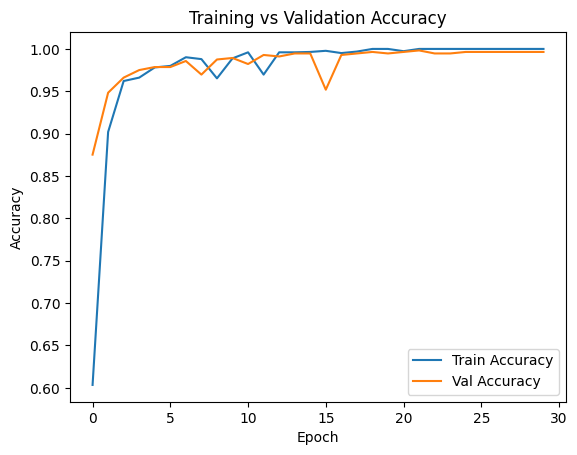

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [ ]:
# Upload audio file and predict
from google.colab import files
import IPython.display as ipd

# Upload .wav file
uploaded = files.upload()

# Get file path
for fname in uploaded.keys():
    file_path = fname
    print("🎧 Playing uploaded audio:")
    ipd.display(ipd.Audio(file_path))

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Predict emotion from uploaded file
def predict_emotion(audio_path):
    audio, sr = librosa.load(audio_path, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfcc = np.mean(mfcc.T, axis=0)
    mfcc = mfcc.reshape(1, -1, 1)
    prediction = model.predict(mfcc)
    emotion = le.inverse_transform([np.argmax(prediction)])
    return emotion[0]

emotion_result = predict_emotion(file_path)
print("✅ Predicted Emotion:", emotion_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
✅ Predicted Emotion: angry
